# Homework 2 Rosini Micol

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Utils cell

def average_time_calculator(G,o,d,w_star,Q, num_simulations):
    
    nodes = list(G.nodes())
    o = nodes.index(o) # origin
    d = nodes.index(d) # destination
    
    returned_times = [] # returned_times will store the different time instants at which the particle returns in the starting node
    
    for simulation in range(num_simulations):
        pos = []
        pos.append(o) # we start from state a
        transition_times = 0 # simulation time
        t_next = -np.log(np.random.rand())/w_star
            
        i = 0
        returned = False
        while not returned:
            
            i += 1
            pos.append(np.random.choice(nstates, p=Q[pos[i-1],:]))
            transition_times += t_next
            if pos[i] == d : # arrived at destination
                returned_times.append(transition_times)
                if simulation == num_simulations/2:
                    pos_j = pos[1:]
                    pos_i = pos[:-1]
                    edges_visited = [(nodes[i],nodes[j]) for i,j in zip(pos_i,pos_j)]
                returned = True
            t_next = -np.log(np.random.rand())/w_star
            
    return sum(returned_times)/ len(returned_times), edges_visited 
    
    
    
def exp_return_times(G,w,o,pi_bar):
    
    nodes = list(G.nodes())
    o = nodes.index(o)
    
    return 1/(w[o]*pi_bar[o])



def theoretical_hitting_time(G,w,Lambda,o,d):
    
    nodes = list(G.nodes())
    origin = nodes.index(o)
    destination = nodes.index(d)
    P_d =[]
    
    for x,wi in zip(Lambda,w):
        p_d = []
        for y in x:
            p_d.append(y/(wi))
        P_d.append(p_d)    
    P_d[destination] = [0]*len(nodes)
    w_inv = []
    for wi in w:
        w_inv.append(1/wi)
    w_inv[destination] = 0
    for i in range(len(G.nodes)):
        P_d[i][i] -= 1
    P_d = -np.array(P_d)
    w_inv = np.array(w_inv)
    result = np.linalg.solve(P_d, w_inv)
    
    return result[origin]


# To check is consensus is reached
def can_reach_consensus(G):
    att_comp = list(nx.attracting_components(G))
    sink_comp = []
    for node in att_comp[0]:
        sink_comp.append(node)
    sink = G.subgraph(sink_comp)
    if nx.number_attracting_components(G) == 1 and nx.is_aperiodic(sink):
        print('The graph can reach consensus')
    if nx.number_attracting_components(G) != 1:
        print('The condensation graph has more than one sink -> no consensus')
    if not nx.is_aperiodic(sink):
        print('The sink component of the graph is not aperiodic')
        
def all_equal(iterator):
    iterator = np.round(iterator, 10)
    return all(i == iterator[0] for i in iterator)
 

def consensus(G,P, x):
    time = 0
    nostop = True
    while nostop == True and time <= 1000:
        time += 10
        for n in range(time):    
            x = P @ x
            if all_equal(x):
                consensus_value = x[0]
                nostop = False
                break
    if nostop == True:
        print('Consensus not reached in 1000 time units')
        return
    return consensus_value,time


def computing_average_variance(G,P,iterations,mean, sigma):  
    consensous_values = []
    for n in range(iterations):
        x0 = np.random.normal(mean, sigma, len(P))
        values_of_consensus, _ = consensus(G,P, x0)
        consensous_values.append(values_of_consensus)
    variance_of_cons = np.var(consensous_values)
    return variance_of_cons

def utils_graph_modified(G, edges, W_):
    
    
    nodes = ['o','a','b','c','d']
    
    for edge in edges:
        
        index_i = nodes.index(edge[0])
        index_j = nodes.index(edge[1])
        W_[index_i][index_j] = 0
    if sum(W_[index_i]) == 0:
        W_[index_i][index_i] =1
    w = np.sum(W_, axis=1)
    w_star = np.max(w)

    Q = W_/w_star # off-diagonal part of Q
    Q = Q + np.diag(np.ones(len(w))-np.sum(Q, axis = 1)) # diagonal part

    # dominant eigenvector
    values,vectors = np.linalg.eig(Q.T)
    index = np.argmax(values.real)
    pi_bar = vectors[:,index].real
    pi_bar = pi_bar/np.sum(pi_bar)

    D = np.diag(w)
    P = np.linalg.inv(D) @ W_
    return W_,P, pi_bar

## Exercise 1

Consider a single particle performing a continuous-time random walk in the network described by the graph above and with the following transition rate matrix:

<div class="math">
    \[\begin{array}{1}& o && a && b && c && d\end{array}\\
        %\begin{array}{1} & o && a && b && c & d\end{array}\\
        \Lambda = 
        \begin{pmatrix}
         0 & 2/5 & 1/5 & 0 & 0 \\
         0 & 0 & 3/4 & 1/4 & 0 \\
         1/2 & 0 & 0 & 1/2 & 0 \\
         0 & 0 & 1/3 & 0 & 2/3 \\
         0 & 1/3 & 0 & 1/3 & 0 
        \end{pmatrix}
        \begin{array}{1}
         o \\ a \\ b \\ c \\ d
        \end{array}
      \] 
</div>



Text(0.5, 1.0, 'Graph of the exercise')

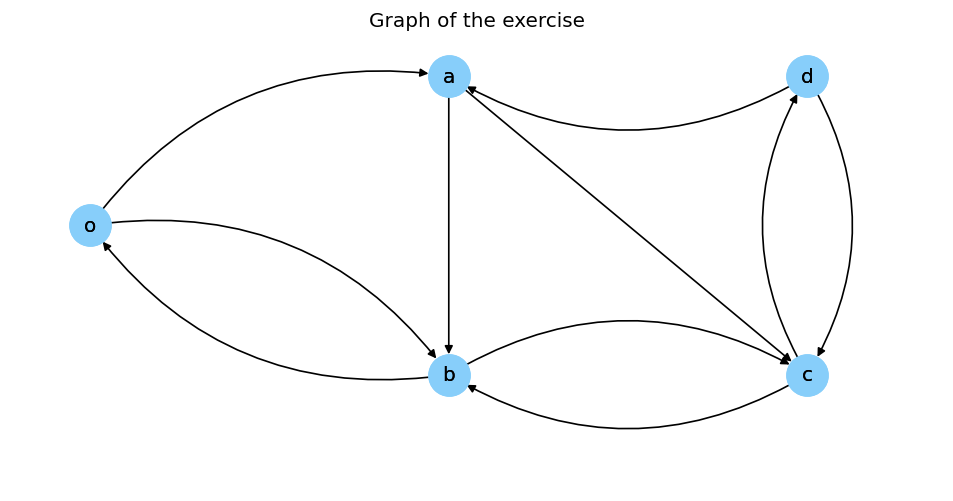

In [3]:
# Script to draw the graph of the exercise

fig, ax = plt.subplots(figsize = (10,5), dpi=120) 

nodes = ['o', 'a', 'b', 'c', 'd']
positions = [(0, 0.5), (0.5, 1), (0.5, 0), (1, 0), (1, 1)]
edges = [('o', 'a'), ('o', 'b'), ('b', 'o'), ('a', 'b'), ('a', 'c'),('b','c'),('c','b'),('d','a'),('d','c'),('c','d')]

G = nx.DiGraph()
G.add_edges_from(edges)
for index, name in enumerate(nodes):
    G.add_node(name, pos=positions[index])
layout = dict((n, G.nodes[n]["pos"]) for n in G.nodes()) # positions
straight_edges = [('a','b'), ('a','c')] # edges to draw with a straight line 
curved_edges = list(set(G.edges()) - set(straight_edges)) # edges to draw with a curved line
arc_rad = -0.3

nx.draw(G, pos=layout, with_labels=True, node_size=600, node_color ='lightskyblue', edgelist = straight_edges)
nx.draw(G, pos=layout, with_labels=True, node_size=600, node_color ='lightskyblue', edgelist = curved_edges,  connectionstyle=f'arc3, rad = {arc_rad}')

plt.savefig('fig/graph1.png')
ax.set_title("Graph of the exercise")


Let's represent the simulation of the particle moving around in the network in continuous time according to the transition rate matrix:

In [4]:
Lambda = [[0, 2/5, 1/5, 0, 0],
          [0, 0, 3/4, 1/4, 0], 
          [1/2, 0, 0, 1/2, 0],
          [0, 0, 1/3, 0, 2/3],
          [0, 1/3, 0, 1/3, 0]]
print('\u039B =','')
for el in Lambda: 
    print(el)

w = np.sum(Lambda, axis=1)
w_star = np.max(w)


Q = Lambda/w_star # off-diagonal part of Q
Q = Q + np.diag(np.ones(len(w))-np.sum(Q, axis = 1)) # diagonal part

# dominant eigenvector
values,vectors = np.linalg.eig(Q.T)
index = np.argmax(values.real)
pi_bar = vectors[:,index].real
pi_bar = pi_bar/np.sum(pi_bar)
nstates = len(pi_bar)

D = np.diag(w)
P = np.linalg.inv(D) @ Lambda

Λ = 
[0, 0.4, 0.2, 0, 0]
[0, 0, 0.75, 0.25, 0]
[0.5, 0, 0, 0.5, 0]
[0, 0, 0.3333333333333333, 0, 0.6666666666666666]
[0, 0.3333333333333333, 0, 0.3333333333333333, 0]


### Question a :
What is, according to the simulations, the average time it takes a particle that starts in node $a$ to leave the node and then return to it?

***Solution*** 


Given a directed graph $G = (\mathcal{V},\mathcal{E})$, the random walk of a particle  from one of its nodes to another can be interpreted as a Poisson process $N_t = X(t)$ on the infinite set of nonnegative integers: that starts in $a$ at time $t = 0$, increases by one unit at every tick of the Poisson clock, and never decreases. \
When **the Poisson clock ticks**, the particle randomly chooses the next node to move to among the out-neighbors of the current node with probability proportional to the row-stochastic matrix $Q$. \
$Q$ is defined in the following way: 
$$
Q_{ij} = \frac{\Lambda_{ij}}{\omega_{*}}, \; i \neq j \quad Q_{ii} = 1 - \sum_{i \neq j} Q_{ij}
$$
with $\omega = \Lambda \mathbf{1}$ and $\omega_{*}=\max_i \omega_i$.



In order to compute the average time it takes a particle that starts in node $a$ to leave the node and then return to it we can use the following function: `average_time_calculator`

In [5]:
avg_return_time, _= average_time_calculator(G, 'a' , 'a' , w_star, Q,  10000)
print('The average time to return in node a:', avg_return_time)

The average time to return in node a: 6.6873006791797485


Text(0.5, 1.0, 'Random walk that starts and ends in node a')

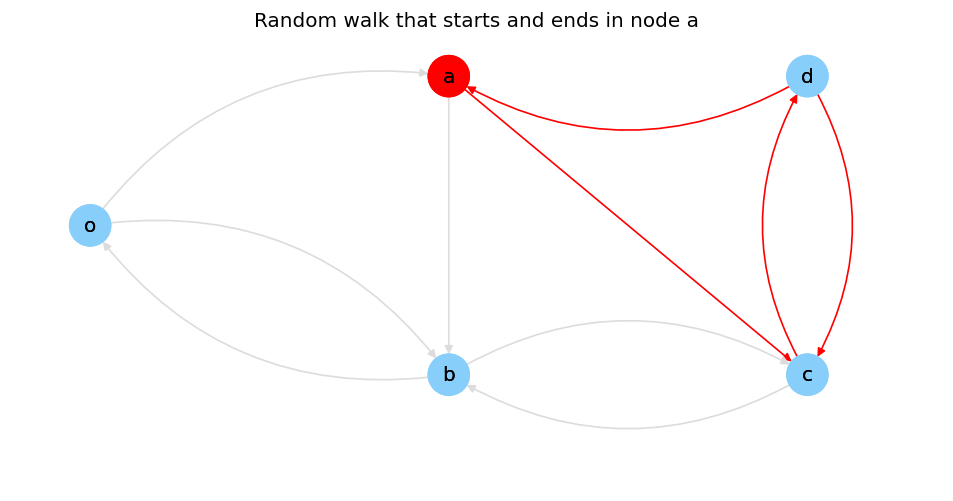

In [6]:
_, edges_visited = average_time_calculator(G, 'a' , 'a' , w_star, Q,  10000)
fig, ax = plt.subplots(figsize = (10,5), dpi=120) 

straight_edges = [('a','b'), ('a','c')] # edges to draw with a straight line 
curved_edges = list(set(G.edges()) - set(straight_edges)) # edges to draw with a curved line
arc_rad = -0.3


straight_visited_edges = [edge for edge in edges_visited if edge in straight_edges]
curved_visited_edges = list(set(edges_visited) - set(straight_visited_edges))
node_color = ['red' if node == 'a' else 'lightskyblue' for node in G.nodes() ]
edge_color_straight = ['red' if edge in straight_visited_edges else 'gainsboro' for edge in straight_edges]
edge_color_curved = ['red' if edge in curved_visited_edges else 'gainsboro' for edge in curved_edges]


nx.draw(G, pos=layout, with_labels=True, node_size=600, node_color =node_color, edge_color=edge_color_straight, edgelist = straight_edges)
nx.draw(G, pos=layout, with_labels=True, node_size=600, node_color =node_color, edge_color=edge_color_curved, edgelist = curved_edges,  connectionstyle=f'arc3, rad = {arc_rad}')

plt.savefig('fig/graph2.png')
ax.set_title("Random walk that starts and ends in node a")


### Question b:
How does the result in $a)$ compare to the theoretical return-time $E_a[T_a^+]$? 

***Solution*** 


The theory states that if the graph $G$ is **strongly connected** the expected return times satisfy 
$$ E_i[\overline{T}^+_i] = \frac{1}{\omega_i\bar{\pi_i}} $$
where $$ \overline{T}_i^+ = \text{inf} \{ t\geq 0 : X(t)=i \text{ and } X(s) \neq i \text{ for some } s \in (0,t) \} $$

$\pi$ represents the stationary probability vector of the continuous-time Markov chain with transition rate matrix $\Lambda$

In [7]:
if nx.is_strongly_connected(G):
    print('The graph is strongly connected')

The graph is strongly connected


In [8]:
expected_return_times = exp_return_times(G,w,'a', pi_bar)
print('The expected return-time is:', expected_return_times)

The expected return-time is: 6.750000000000007


### Question c:
What is, according to the simulations, the average time it takes to move from node $o$ to node $d$?


***solution***


The anser can be found using the same function `average_time_calculator` changing the input and output nodes

In [9]:
avg_hitting_time, _= average_time_calculator(G, 'o' , 'd' , w_star, Q, 10000)
print('the average time it takes to move from node o to node d is: ',avg_hitting_time)

the average time it takes to move from node o to node d is:  8.775312119780223


Text(0.5, 1.0, 'Random walk that starts in node o and ends in node d')

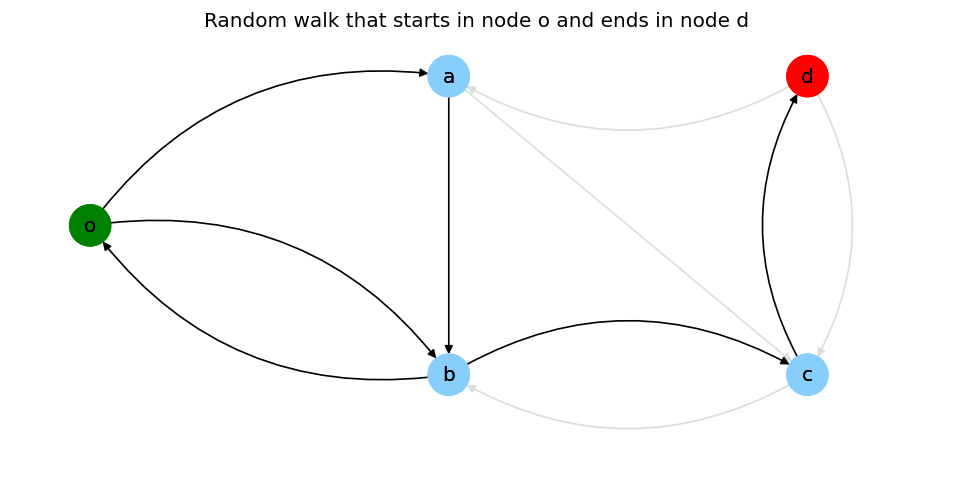

In [10]:
_, edges_visited = average_time_calculator(G, 'o' , 'd' , w_star, Q, 10000)
fig, ax = plt.subplots(figsize = (10,5), dpi=120) 

straight_edges = [('a','b'), ('a','c')] # edges to draw with a straight line 
curved_edges = list(set(G.edges()) - set(straight_edges)) # edges to draw with a curved line
arc_rad = -0.3


straight_visited_edges = [edge for edge in edges_visited if edge in straight_edges]
curved_visited_edges = list(set(edges_visited) - set(straight_visited_edges))
node_color = ['green' if node == 'o' else 'red' if node == 'd' else 'lightskyblue' for node in G.nodes() ]
edge_color_straight = ['black' if edge in straight_visited_edges else 'gainsboro' for edge in straight_edges]
edge_color_curved = ['black' if edge in curved_visited_edges else 'gainsboro' for edge in curved_edges]


nx.draw(G, pos=layout, with_labels=True, node_size=600, node_color =node_color, edge_color=edge_color_straight, edgelist = straight_edges)
nx.draw(G, pos=layout, with_labels=True, node_size=600, node_color =node_color, edge_color=edge_color_curved, edgelist = curved_edges,  connectionstyle=f'arc3, rad = {arc_rad}')

plt.savefig('fig/graph3.png')
ax.set_title("Random walk that starts in node o and ends in node d")

### Question d:
How does the result in $c)$ compare to the theoretical hitting-time $E_o[T_d]$? 

Let $d$ be the node that we want to reach. The theoretical hitting-time $E_o[T_d]$ for a **strongly connected** graph is computed in the following way:

$$ \overline{\tau}_i^d = \mathbf{E}_i[T_d]$$

$$ \overline{\tau}_i^d = 0  \ \ \ \text{ if } \ \ \   i = d$$

$$ \overline{\tau}_i^d = \dfrac{1}{w_i} + \sum_{j} P_{i,j} \mathbf{E}_j[T_d] \ \ \ \text{ if } \ \ \  i \neq d $$

P is the matrix of transition probabilities and for the node $d$ it is defined in the following way:
$$ P_{d_{ij}} = 
\begin{cases}
	P_{i,j} &\text{   if   } \ i \neq d \\
	0 &\text{   if    } i = d
\end{cases} 
$$

$$
\overline{\tau}_i^d =\dfrac{1}{w_d}  + P_d \mathbf{E}[T_d] 
$$
where $$ \frac{1}{w_i} = 
	0 \text{  if   } i = d$$

In [11]:
print('The theoretical hitting time is: ',theoretical_hitting_time(G,w,Lambda,'o','d'))

The theoretical hitting time is:  8.785714285714285


## Question e

Interpret the matrix $\Lambda$ as the weight matrix of a graph $G = (\mathcal{V},\mathcal{E},\Lambda)$, and simulate the French- DeGroot dynamics on G with an arbitrary initial condition x(0). Does the dynamics converge to a consensus state for every initial condition x(0)?


***Solution***


The theory states that the dynamic converges to the consensus state if:
- its condensation graph has 1 sink;
- the sink component of the graph is aperiodic;

$$\Rightarrow\lim_{t \to +\infty} x(t) = \alpha \mathbf{1}$$

Let's check these conditions with the function : `can_reach_consensus`

The graph can reach consensus


Text(0.5, 1.0, 'The condensation graph')

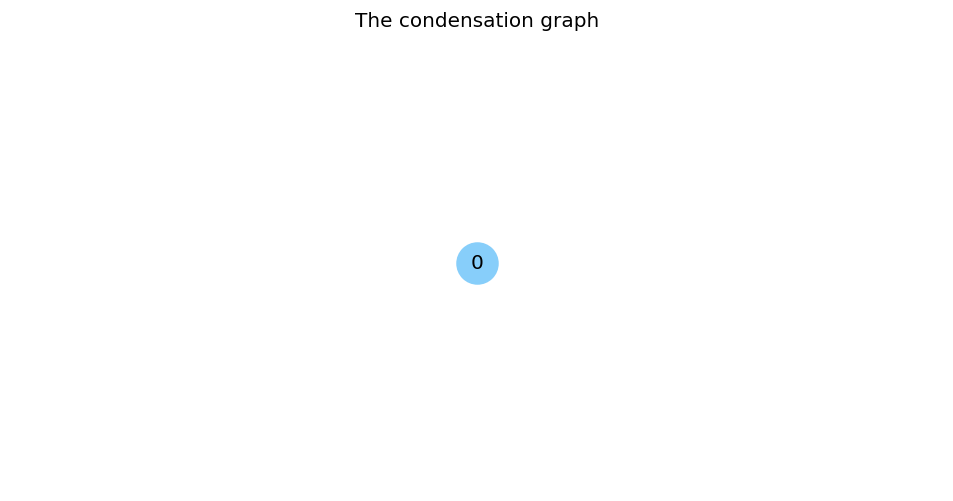

In [12]:
CG = nx.algorithms.components.condensation(G)
can_reach_consensus(G)
fig, ax = plt.subplots(figsize = (10,5), dpi=120) 
nx.draw(CG, with_labels=True, node_size=600, node_color ='lightskyblue')
plt.savefig('fig/graph4.png')
ax.set_title("The condensation graph")

## Question f

Assume that the initial state of the dynamics for each node $i \in \mathcal{V}$ is given by $x_i(0) = \xi_i$, where \{ $\xi_i$\}_{$i \in \mathcal{V}$} are i.i.d random variables with variance $\sigma^2$. Compute the variance of the consensus value, and compare your results with numerical simulations.

***Solution***

In [13]:
W = Lambda
degrees = w 
x0 = np.random.rand(len(G.nodes)) # Initial condition    
consensus_value, consensus_time = consensus(G,P, x0)
print("The consensus is:")
print("x(",consensus_time,"):", consensus_value, "\n")          

The consensus is:
x( 40 ): 0.6007383303213963 



The theory states that if $\xi_i$ are independent with the same variance $\sigma^2$. In this case, the variance of the asymptotic consensus value $X$
satisfies:
$$ \sigma_{\bar{x}}^2 = \sigma^2 \sum_i\pi_i^2$$

In [14]:
# Dominant eigenvector
values,vectors = np.linalg.eig(P.T)
index = np.argmax(values.real)
pi_bar = vectors[:,index].real
pi_bar = pi_bar/np.sum(pi_bar)
print('The dominant eigenvector is:', pi_bar)

The dominant eigenvector is: [0.13043478 0.17391304 0.26086957 0.26086957 0.17391304]


In [15]:
# Theoretical computation of variance of consensus
sigma = 0.3 # For example
v_theor = np.sum(np.square(pi_bar)*(sigma**2))
print('Theoretical computation of variance of consensus is:',v_theor)

Theoretical computation of variance of consensus is: 0.019224952741020793


In order to compare the extpected result with a numerical simulation let's set the $\sigma^2$ value to $0.3$ and the mean value to $0.8$

In [16]:
sigma = 0.3 
mean = 0.8
iterations = 1000
variance_of_cons = computing_average_variance(G,P,iterations,mean, sigma)
print('The variance of consensus by numerical simulations is : ', variance_of_cons)

The variance of consensus by numerical simulations is :  0.019803210954801087


## Question g
Remove the edges $(d,a)$ and $(d,c)$. Describe and motivate the asymptotic behaviour of the dynamics. If the dynamics converges to a consensus state, how is the consensus value related to the initial condition $x(0)$? Assume that the initial state of the dynamics for each node $i \in \mathcal{V}$  is given by $x_i(0) = \xi_i$, where \{ $\xi_i$\}_{$i \in \mathcal{V}$} are i.i.d random variables with variance $\sigma^2$. Compute the variance of the consensus value.

***Solution***

Text(0.5, 1.0, 'Graph without the edges (d,a) and (d,c)')

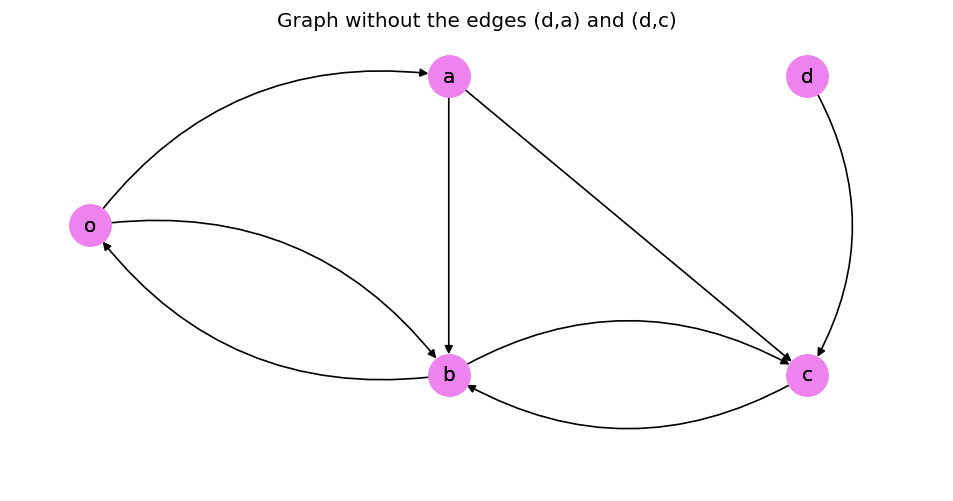

In [17]:
nodes = ['o', 'a', 'b', 'c', 'd']
positions = [(0, 0.5), (0.5, 1), (0.5, 0), (1, 0), (1, 1)]
edges = set(G.edges()) - set([('d','a'),('c','d')])

G1 = nx.DiGraph()
G1.add_edges_from(edges)
for index, name in enumerate(nodes):
    G1.add_node(name, pos=positions[index])
    

layout = dict((n, G1.nodes[n]["pos"]) for n in G.nodes())

straight_edges = [('a','b'), ('a','c')]
curved_edges = list(set(G1.edges()) - set(straight_edges))

arc_rad = -0.3

fig, ax = plt.subplots(figsize = (10,5), dpi=120) 


nx.draw(G1, pos=layout, with_labels=True, node_size=600, node_color ='violet', edgelist = straight_edges)
nx.draw(G1, pos=layout, with_labels=True, node_size=600, node_color ='violet', edgelist = curved_edges,  connectionstyle=f'arc3, rad = {arc_rad}')


plt.savefig('fig/graph5.png')
ax.set_title("Graph without the edges (d,a) and (d,c)")

The number of components in the consensation graph is: 2
The graph is not aperiodic
The graph is not strongly connected


Text(0.5, 1.0, 'The condensation graph of the modified graph')

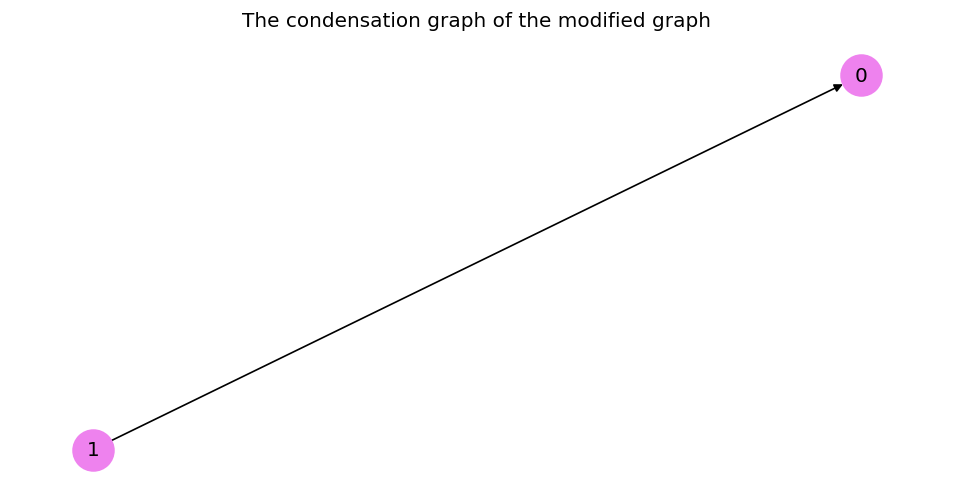

In [18]:
CG1 = nx.condensation(G1)
print('The number of components in the consensation graph is:',len(CG1.nodes()))
if nx.is_aperiodic(G1):
    print('The graph is aperiodic')
else:
    print('The graph is not aperiodic')
if nx.is_strongly_connected(G1):
    print('The graph is strongly connected')
else:
    print('The graph is not strongly connected')


fig, ax = plt.subplots(figsize = (10,5), dpi=120) 
nx.draw(CG1, with_labels=True, node_size=600, node_color ='violet')
plt.savefig('fig/graph6.png')
ax.set_title("The condensation graph of the modified graph")

The new graph is not strongly connected. The theory states that if the graph is not strongly connected, but its condensation graph has one sink:
- the averaging dynamics converges to a consensus, whose value depends only on the initial state of nodes of the sink;
- the linear flow dynamics converges to the dominant eigenvector of $P'$, which has support only on the nodes of the sink.

In order to check if the graph satisfies the condition to consensus first we have to check if the number of attracting components in the condensation graph is 1. Then, to check the aperiodicity of the sink component in G1, we apply the function nx.is_aperiodic(G1) on the attracting component of G1.
This checks are done with the following function: `can_reach_consensus`.

In [19]:
can_reach_consensus(G1)

The graph can reach consensus


We can see that the following modified graph can reach the consensus

The modified graph will have a different weight matrix W, and so, a different P.
With `utils_graph_modified`

In [20]:
W1,P1,pi_bar1 = utils_graph_modified(G1, [('d','a'),('d','c')], W)

In [21]:
x0 = np.random.rand(len(G1.nodes)) # Initial condition    
consensous_value, consensous_time = consensus(G1,P1, x0)
print('The consensus value for this modified graph:')
print("x(",consensous_time,"):", consensous_value, "\n")

The consensus value for this modified graph:
x( 50 ): 0.3220878340485285 



In [22]:
sigma = 0.3 
mean = 0.8
iterations = 1000
variance_of_cons = computing_average_variance(G1,P1,iterations,mean, sigma)
print('The variance of consensus by numerical simulations is : ', variance_of_cons)

The variance of consensus by numerical simulations is :  0.09400796875041781


In [23]:
# Theoretical computation of variance of consensus
sigma = 0.3 # For example
print('The dominant eigenvector:', pi_bar1)
v_theor = np.sum(np.square(pi_bar1)*(sigma**2))
print('Theoretical computation of variance of consensus is:',v_theor)

The dominant eigenvector: [0. 0. 0. 0. 1.]
Theoretical computation of variance of consensus is: 0.09


## Question h 
Consider the graph $(\mathcal{V} ,\mathcal{E} , \mathcal{\Lambda})$, and remove the edges $(c, b)$ and $(d, a)$. Analyse the French- DeGroot dynamics on the new graph. In particular, describe and motivate the asymptotic behaviour of the dynamics in terms of the initial condition x(0).


Text(0.5, 1.0, 'Graph without the edges (c,b) and (d,a)')

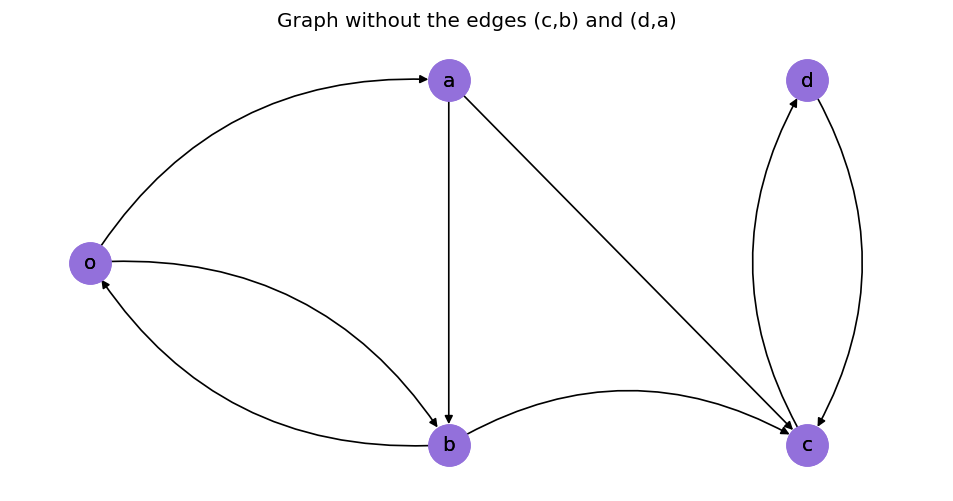

In [24]:
nodes = ['o', 'a', 'b', 'c', 'd']
positions = [(0, 0.5), (0.5, 1), (0.5, 0), (1, 0), (1, 1)]
edges = set(G.edges()) - set([('c','b'),('d','a')])

G2 = nx.DiGraph()
G2.add_edges_from(edges)
for index, name in enumerate(nodes):
    G2.add_node(name, pos=positions[index])
    

layout = dict((n, G2.nodes[n]["pos"]) for n in G2.nodes())

straight_edges = [('a','b'), ('a','c')]
curved_edges = list(set(G2.edges()) - set(straight_edges))

arc_rad = -0.3

fig, ax = plt.subplots(figsize = (10,5), dpi=120) 


nx.draw(G2, pos=layout, with_labels=True, node_size=600, node_color ='mediumpurple', edgelist = straight_edges)
nx.draw(G2, pos=layout, with_labels=True, node_size=600, node_color ='mediumpurple', edgelist = curved_edges,  connectionstyle=f'arc3, rad = {arc_rad}')


plt.savefig('fig/graph7.png')
ax.set_title("Graph without the edges (c,b) and (d,a)")

Text(0.5, 1.0, 'The condensation graph of the second modified graph')

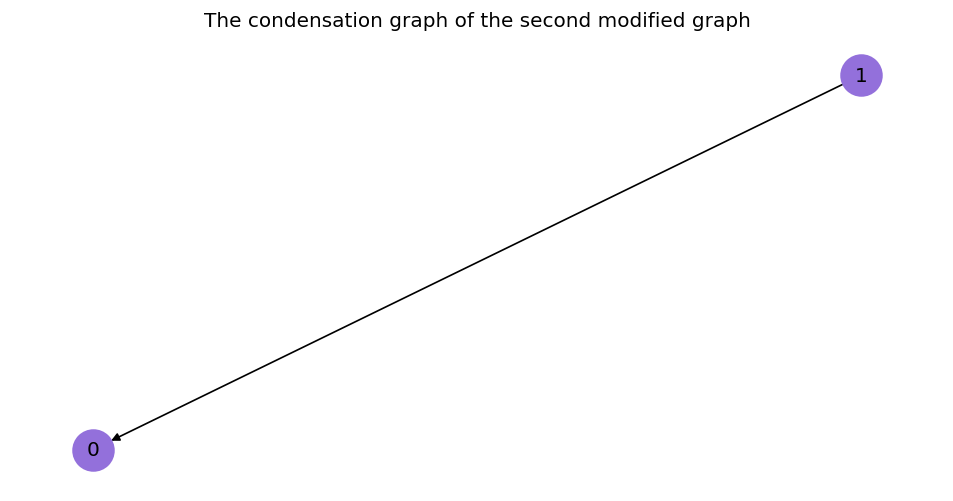

In [25]:
CG2 = nx.condensation(G2)
fig, ax = plt.subplots(figsize = (10,5), dpi=120) 
nx.draw(CG2, with_labels=True, node_size=600, node_color ='mediumpurple')

plt.savefig('fig/graph8.png')
ax.set_title("The condensation graph of the second modified graph")

In [26]:
print('The components of the condensation graph are:',list(nx.strongly_connected_components(G2)))
print('The sink component in the condensation graph is made by:',list(nx.attracting_components(G2)))

The components of the condensation graph are: [{'c', 'd'}, {'b', 'o', 'a'}]
The sink component in the condensation graph is made by: [{'c', 'd'}]


In [27]:
can_reach_consensus(G2)

The sink component of the graph is not aperiodic


Now the sink component of the graph is not aperiodic, so a consensus will (generally) not be reached.

A consensus will be reached only in the cases where the initial opinions of the sink components coincide,i.e,:
$$x_c(0) = x_d(0)$$

In [28]:
Lambda = [[0, 2/5, 1/5, 0, 0],
          [0, 0, 3/4, 1/4, 0], 
          [1/2, 0, 0, 1/2, 0],
          [0, 0, 1/3, 0, 2/3],
          [0, 1/3, 0, 1/3, 0]]
W = Lambda
W2,P2,pi_bar2 = utils_graph_modified(G2, [('d','a'),('c','b')], W)
x_0 = np.random.rand(len(G2.nodes)) # Initial condition    
consensus(G2,P2,x_0)

Consensus not reached in 1000 time units
